# Amazon Reviews Sentiment - ML Text Analysis 1
Includes
* Basic Implementation using Naive Bayes
* VADERS(Valence Aware Dictionary for Sentiment Reasoning) 
* Roberta

In [1]:
pip install pymongo[srv]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymongo

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import nltk

# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/amazon-review-for-text-and-sentiment-analysis/amazon_reviews_text_analysis (1).csv


In [3]:
print(pymongo.__version__)

3.13.0


#### Load data source

In [4]:
reviews_df = pd.read_csv("/kaggle/input/amazon-review-for-text-and-sentiment-analysis/amazon_reviews_text_analysis (1).csv")
print(reviews_df.shape)
reviews_df.info()

(249, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            249 non-null    object
 1   PRODUCTNAME   249 non-null    object
 2   REVIEW        240 non-null    object
 3   REVIEWERNAME  231 non-null    object
 4   POSITIVE      249 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 9.9+ KB


Data Preparation

In [5]:
# strip spaces
reviews_df.columns = reviews_df.columns.str.strip()
# clean column names
reviews_df.columns = reviews_df.columns.str.replace(' ', '_')
# preference - conver all columns names to upper case
reviews_df.columns = reviews_df.columns.str.upper()
#rename
reviews_df = reviews_df.rename(columns={"POSITIVE": "LABELLED_SENTIMENT"})
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  249 non-null    object
 1   PRODUCTNAME         249 non-null    object
 2   REVIEW              240 non-null    object
 3   REVIEWERNAME        231 non-null    object
 4   LABELLED_SENTIMENT  249 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 9.9+ KB


In [6]:
print(reviews_df['LABELLED_SENTIMENT'].unique())

[0 1]


In [7]:
# remove unecessary columns
df = reviews_df.drop(columns=['REVIEWERNAME']
                            )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  249 non-null    object
 1   PRODUCTNAME         249 non-null    object
 2   REVIEW              240 non-null    object
 3   LABELLED_SENTIMENT  249 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 7.9+ KB


#### Explore

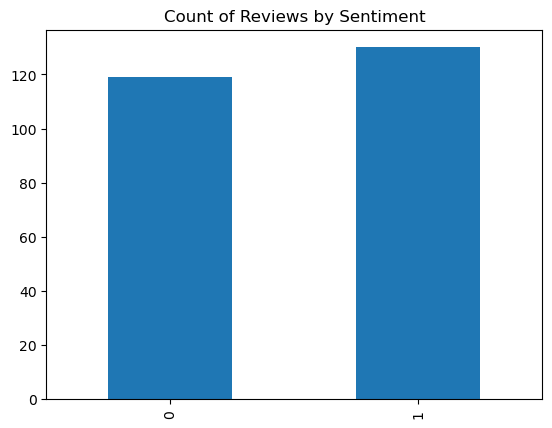

In [9]:
# plot count of reviews by Sentiment
ax = df['LABELLED_SENTIMENT'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment'

         )
ax.set_xlabel = 'Reivew Sentiment'

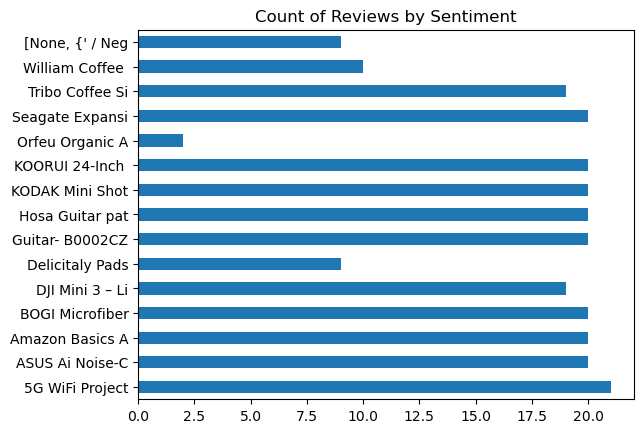

In [10]:
# plot count of reviews by Sentiment
ax = df['PRODUCTNAME'].str[:15].value_counts().sort_index() \
    .plot(kind='barh',
          title='Count of Reviews by Sentiment'

         )
ax.set_xlabel = 'Reivew Sentiment'

In [11]:
df.isna().sum()

ID                    0
PRODUCTNAME           0
REVIEW                9
LABELLED_SENTIMENT    0
dtype: int64

In [12]:
df = df.dropna()

## Basic Implementation - with Naive Bayes

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Preparing the data
X = df['REVIEW']
y = df['LABELLED_SENTIMENT']

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data into numerical features (Bag of Words)
vectorizer = CountVectorizer()

# Fit and transform the training data into numerical features
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_vectorized = vectorizer.transform(X_test)

#### Results

Accuracy: 0.67


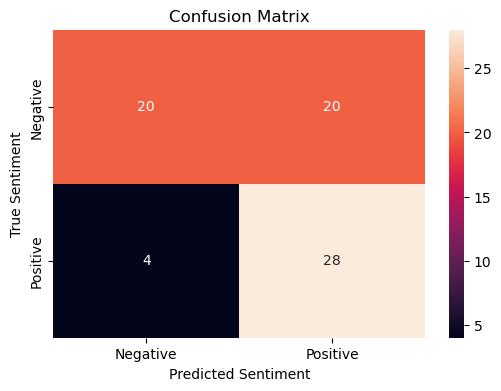

In [14]:
# Create a Naive Bayes classifier and train it on the training data
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test_vectorized)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.show()

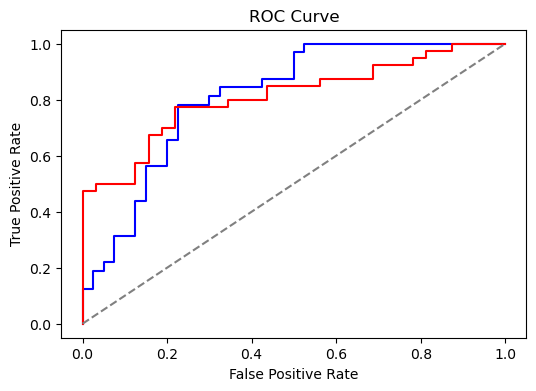

AUC: 0.81
AUC: 0.81


In [15]:
prob_pos = clf.predict_proba(X_test_vectorized)[:, 1]
prob_neg = clf.predict_proba(X_test_vectorized)[:, 0]

# Convert the problem to binary classification
# Assume you have a binary target variable, where 1 represents positive sentiment
binary_true_pos_sentiment = (y_test == 1).astype(int)
binary_true_neg_sentiment = (y_test == 0).astype(int)


# ROC Curve
fpr_pos, tpr_pos, _ = roc_curve(binary_true_pos_sentiment, prob_pos)
fpr_neg, tpr_neg, _ = roc_curve(binary_true_neg_sentiment, prob_neg)

plt.figure(figsize=(6, 4))
plt.plot(fpr_pos, tpr_pos, color='b', label='Positive')
plt.plot(fpr_neg, tpr_neg, color='r', label='Positive')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# If you want to calculate the AUC (Area Under the Curve)
roc_auc_pos = roc_auc_score(binary_true_pos_sentiment, prob_pos)
roc_auc_neg = roc_auc_score(binary_true_neg_sentiment, prob_neg)
print(f'AUC: {roc_auc_pos:.2f}')
print(f'AUC: {roc_auc_neg:.2f}')

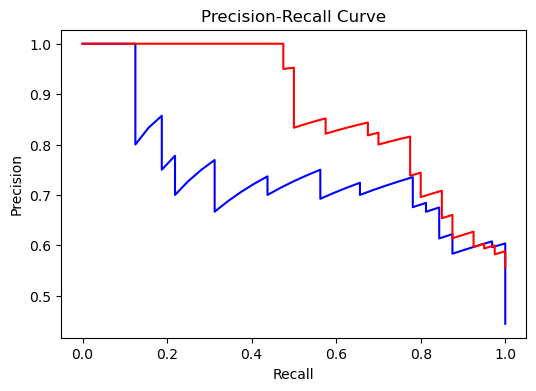

Average Precision: 0.75
Average Precision: 0.87


In [16]:

# Precision-Recall Curve
precision_pos, recall_pos, _ = precision_recall_curve(binary_true_pos_sentiment, prob_pos)
precision_neg, recall_neg, _ = precision_recall_curve(binary_true_neg_sentiment, prob_neg)
plt.figure(figsize=(6, 4))
plt.plot(recall_pos, precision_pos, color='b')
plt.plot(recall_neg, precision_neg, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# If you want to calculate the Average Precision
avg_precision_pos = average_precision_score(binary_true_pos_sentiment, prob_pos)
avg_precision_neg = average_precision_score(binary_true_neg_sentiment, prob_neg)
print(f'Average Precision: {avg_precision_pos:.2f}')
print(f'Average Precision: {avg_precision_neg:.2f}')

## VADERS (Valence Aware Dictionary for Sentiment Reasoning) 
Uses NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.  
This uses a "bag of words" approach:
* Stop words are removed
* each word is scored and combined to a total score.

In [17]:
pip install twython

Note: you may need to restart the kernel to use updated packages.


In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
#Efrom tqdm.notebook import tqdm # for iteration progress bar
from tqdm import tqdm, trange
from tqdm.auto import tqdm

sia = SentimentIntensityAnalyzer()

#### samples

In [19]:
print(df['REVIEW'][1])
sia.polarity_scores(df['REVIEW'][1])

Is okWork for me, does all I need


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [20]:
print(df['REVIEW'][3])
sia.polarity_scores(df['REVIEW'][3])

As advertised - I started making videos and was quickly running out of room but didn't want to just delete them, so I looked into portable storage. I use a laptop and it's a 2TB. This portable HDD is TWICE that! So I don't have to worry about space for quite a while! Plugged it in, started transferring and once it was done, I checked a couple vids to make sure they transferred properly. And they did! Had over 600GB to transfer so it took about 20min. Not gonna wait as long to transfer next time so it won't take as long. Would absolutely recommend for the price


{'neg': 0.013, 'neu': 0.887, 'pos': 0.1, 'compound': 0.8831}

#### get polarity scores for all dataset rows

In [21]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['REVIEW']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)
    
res

  0%|          | 0/240 [00:00<?, ?it/s]

{'64c95b84aaf13e5ac224e13f': {'neg': 0.044,
  'neu': 0.904,
  'pos': 0.052,
  'compound': 0.1531},
 '64c95b84aaf13e5ac224e140': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 '64c95b84aaf13e5ac224e141': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 '64c95b84aaf13e5ac224e142': {'neg': 0.013,
  'neu': 0.887,
  'pos': 0.1,
  'compound': 0.8831},
 '64c95b84aaf13e5ac224e143': {'neg': 0.065,
  'neu': 0.817,
  'pos': 0.117,
  'compound': 0.6054},
 '64c95b84aaf13e5ac224e144': {'neg': 0.132,
  'neu': 0.82,
  'pos': 0.048,
  'compound': -0.7986},
 '64c95b84aaf13e5ac224e145': {'neg': 0.184,
  'neu': 0.783,
  'pos': 0.033,
  'compound': -0.9327},
 '64c95b84aaf13e5ac224e146': {'neg': 0.246,
  'neu': 0.669,
  'pos': 0.085,
  'compound': -0.7163},
 '64c95b84aaf13e5ac224e147': {'neg': 0.32,
  'neu': 0.68,
  'pos': 0.0,
  'compound': -0.765},
 '64c95b84aaf13e5ac224e148': {'neg': 0.115,
  'neu': 0.832,
  'pos': 0.053,
  'compound': -0.3182},
 '64c95b84aaf13e5ac224e149': {'

In [22]:
vaders_df = pd.DataFrame(res).T
vaders_df = vaders_df.reset_index().rename(columns={'index': 'ID'})
vaders_df.columns = vaders_df.columns.str.upper()
vaders_df = vaders_df.merge(df, how='left')
vaders_df.iloc[:,1:] # exclude ID from display

,NEG,NEU,POS,COMPOUND,PRODUCTNAME,REVIEW,LABELLED_SENTIMENT
0,0.044,0.904,0.052,0.1531,Seagate Expansion portable 1TB External Hard D...,"11 Months and it Crashed, the good part is, it...",0
1,0.000,1.000,0.000,0.0000,Seagate Expansion portable 1TB External Hard D...,"Is okWork for me, does all I need",1
2,0.000,1.000,0.000,0.0000,Seagate Expansion portable 1TB External Hard D...,#NAME?,1
3,0.013,0.887,0.100,0.8831,Seagate Expansion portable 1TB External Hard D...,As advertised - I started making videos and wa...,1
4,0.065,0.817,0.117,0.6054,Seagate Expansion portable 1TB External Hard D...,Drive failed within the fist two months - Thi...,0
...,...,...,...,...,...,...,...
235,0.058,0.842,0.100,0.6472,Guitar- B0002CZUUG \n,I'm updating a previous negative review. I had...,0
236,0.068,0.814,0.119,0.9356,Guitar- B0002CZUUG \n,The Epiphone Les Paul guitars don't particular...,1
237,0.057,0.782,0.161,0.9608,Guitar- B0002CZUUG \n,I purchased this guitar after much thoughtful ...,1
238,0.010,0.798,0.192,0.9982,Guitar- B0002CZUUG \n,I have been playing for about 7 years now and ...,1


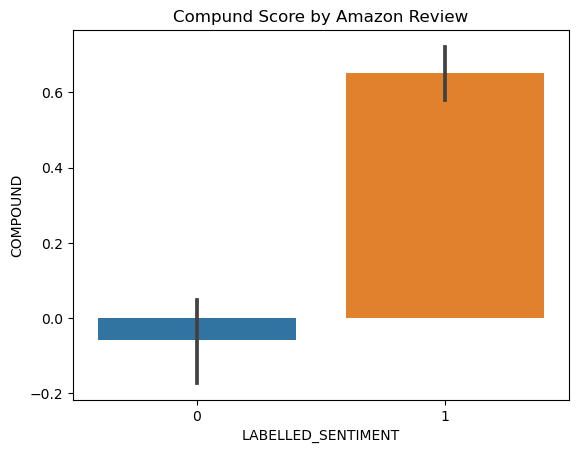

In [23]:
# plot
ax = sns.barplot(data=vaders_df, x='LABELLED_SENTIMENT', y='COMPOUND')
ax.set_title('Compund Score by Amazon Review')
plt.show()

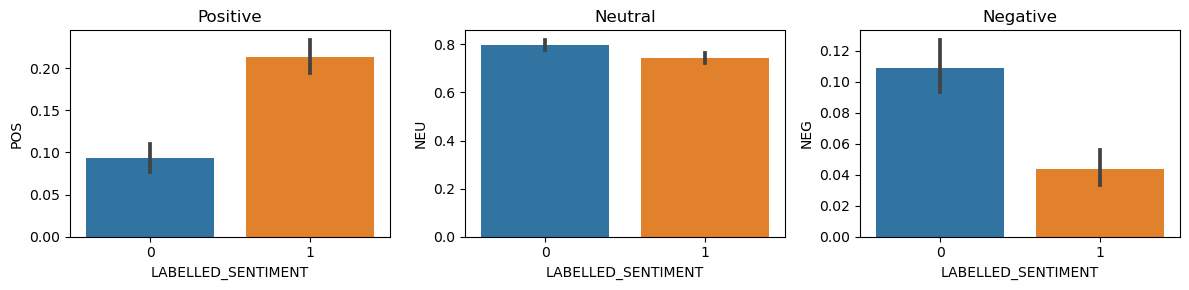

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders_df, x='LABELLED_SENTIMENT', y='POS', ax=axs[0])
sns.barplot(data=vaders_df, x='LABELLED_SENTIMENT', y='NEU', ax=axs[1])
sns.barplot(data=vaders_df, x='LABELLED_SENTIMENT', y='NEG', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [25]:
vaders_df['PREDICTED_SENTIMENT'] = vaders_df['COMPOUND'].apply(lambda x: 1 if x > 0 else 0)
vaders_df.iloc[:,1:] # exclude ID from display

,NEG,NEU,POS,COMPOUND,PRODUCTNAME,REVIEW,LABELLED_SENTIMENT,PREDICTED_SENTIMENT
0,0.044,0.904,0.052,0.1531,Seagate Expansion portable 1TB External Hard D...,"11 Months and it Crashed, the good part is, it...",0,1
1,0.000,1.000,0.000,0.0000,Seagate Expansion portable 1TB External Hard D...,"Is okWork for me, does all I need",1,0
2,0.000,1.000,0.000,0.0000,Seagate Expansion portable 1TB External Hard D...,#NAME?,1,0
3,0.013,0.887,0.100,0.8831,Seagate Expansion portable 1TB External Hard D...,As advertised - I started making videos and wa...,1,1
4,0.065,0.817,0.117,0.6054,Seagate Expansion portable 1TB External Hard D...,Drive failed within the fist two months - Thi...,0,1
...,...,...,...,...,...,...,...,...
235,0.058,0.842,0.100,0.6472,Guitar- B0002CZUUG \n,I'm updating a previous negative review. I had...,0,1
236,0.068,0.814,0.119,0.9356,Guitar- B0002CZUUG \n,The Epiphone Les Paul guitars don't particular...,1,1
237,0.057,0.782,0.161,0.9608,Guitar- B0002CZUUG \n,I purchased this guitar after much thoughtful ...,1,1
238,0.010,0.798,0.192,0.9982,Guitar- B0002CZUUG \n,I have been playing for about 7 years now and ...,1,1


#### Results

Accuracy: 0.7583333333333333


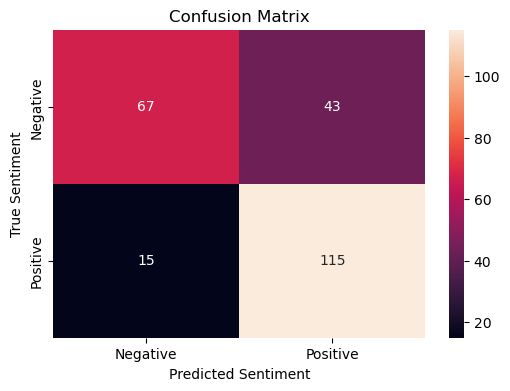

In [26]:
# Calculate the accuracy
accuracy = (vaders_df['LABELLED_SENTIMENT'] == vaders_df['PREDICTED_SENTIMENT']).mean()
print("Accuracy:", accuracy)


conf_mat = confusion_matrix(vaders_df['LABELLED_SENTIMENT'], vaders_df['PREDICTED_SENTIMENT'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.show()

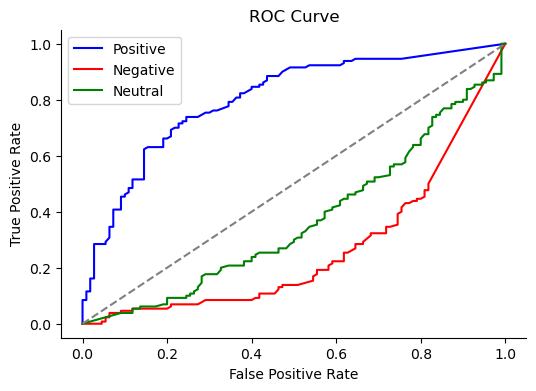

AUC - Positive: 0.80
AUC - Negative: 0.26
AUC - Neutral: 0.37


In [27]:
# columns for positive, negative, neutral
fpr_pos, tpr_pos, _ = roc_curve(vaders_df['LABELLED_SENTIMENT'], vaders_df['POS'])
fpr_neg, tpr_neg, _ = roc_curve(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEG'])
fpr_neu, tpr_neu, _ = roc_curve(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEU'])

plt.figure(figsize=(6, 4))
plt.plot(fpr_pos, tpr_pos, color='b', label='Positive')
plt.plot(fpr_neg, tpr_neg, color='r', label='Negative')
plt.plot(fpr_neu, tpr_neu, color='g', label='Neutral')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
sns.despine()
plt.show()

# calculate the AUC (Area Under the Curve) for each
roc_auc_pos = roc_auc_score(vaders_df['LABELLED_SENTIMENT'], vaders_df['POS'])
roc_auc_neg = roc_auc_score(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEG'])
roc_auc_neu = roc_auc_score(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEU'])

print(f'AUC - Positive: {roc_auc_pos:.2f}')
print(f'AUC - Negative: {roc_auc_neg:.2f}')
print(f'AUC - Neutral: {roc_auc_neu:.2f}')

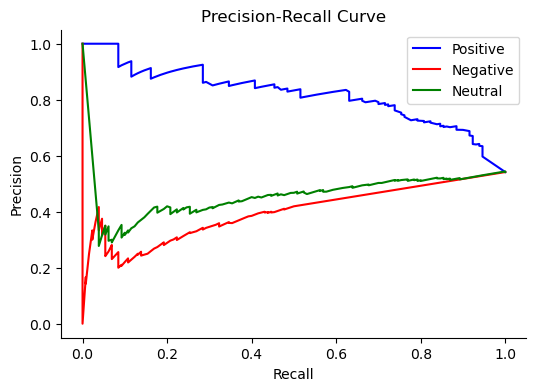

Average Precision - Positive: 0.82
Average Precision - Negative: 0.44
Average Precision - Neutral: 0.46


In [28]:
# columns for positive, negative, neutral
precision_pos, recall_pos, _ = precision_recall_curve(vaders_df['LABELLED_SENTIMENT'], vaders_df['POS'])
precision_neg, recall_neg, _ = precision_recall_curve(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEG'])
precision_neu, recall_neu, _ = precision_recall_curve(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEU'])

plt.figure(figsize=(6, 4))
plt.plot(recall_pos, precision_pos, color='b', label='Positive')
plt.plot(recall_neg, precision_neg, color='r', label='Negative')
plt.plot(recall_neu, precision_neu, color='g', label='Neutral')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
sns.despine()
plt.show()

# If you want to calculate the Average Precision for each sentiment
avg_precision_pos = average_precision_score(vaders_df['LABELLED_SENTIMENT'], vaders_df['POS'])
avg_precision_neg = average_precision_score(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEG'])
avg_precision_neu = average_precision_score(vaders_df['LABELLED_SENTIMENT'], vaders_df['NEU'])

print(f'Average Precision - Positive: {avg_precision_pos:.2f}')
print(f'Average Precision - Negative: {avg_precision_neg:.2f}')
print(f'Average Precision - Neutral: {avg_precision_neu:.2f}')

## Roberta Pretrained Model
* Use a model trained of a large corpus of data.
* Transformer model accounts for the words but also the context related to other words.

In [29]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [31]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [32]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['REVIEW']
        myid = row['ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/240 [00:00<?, ?it/s]

Broke for id 64c95b84aaf13e5ac224e1c8
Broke for id 64c95b84aaf13e5ac224e21d
Broke for id 64c95b84aaf13e5ac224e220
Broke for id 64c95b84aaf13e5ac224e222
Broke for id 64c95b84aaf13e5ac224e223
Broke for id 64c95b84aaf13e5ac224e226
Broke for id 64c95b84aaf13e5ac224e22d


In [33]:
roberta_df = pd.DataFrame(res).T
roberta_df = roberta_df.reset_index().rename(columns={'index': 'ID'})
roberta_df = roberta_df.merge(df, how='left')
roberta_df.iloc[:,1:] # exclude ID from display

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,PRODUCTNAME,REVIEW,LABELLED_SENTIMENT
0,0.044,0.904,0.052,0.1531,0.249284,0.399241,0.351474,Seagate Expansion portable 1TB External Hard D...,"11 Months and it Crashed, the good part is, it...",0
1,0.000,1.000,0.000,0.0000,0.012138,0.457290,0.530572,Seagate Expansion portable 1TB External Hard D...,"Is okWork for me, does all I need",1
2,0.000,1.000,0.000,0.0000,0.172159,0.753018,0.074823,Seagate Expansion portable 1TB External Hard D...,#NAME?,1
3,0.013,0.887,0.100,0.8831,0.021723,0.128118,0.850159,Seagate Expansion portable 1TB External Hard D...,As advertised - I started making videos and wa...,1
4,0.065,0.817,0.117,0.6054,0.683064,0.261081,0.055855,Seagate Expansion portable 1TB External Hard D...,Drive failed within the fist two months - Thi...,0
...,...,...,...,...,...,...,...,...,...,...
228,0.032,0.840,0.128,0.8886,0.046660,0.244539,0.708801,Guitar- B0002CZUUG \n,"Listen,If you want an inexpensive guitar with ...",1
229,0.058,0.842,0.100,0.6472,0.113744,0.310768,0.575488,Guitar- B0002CZUUG \n,I'm updating a previous negative review. I had...,0
230,0.068,0.814,0.119,0.9356,0.064299,0.335430,0.600271,Guitar- B0002CZUUG \n,The Epiphone Les Paul guitars don't particular...,1
231,0.057,0.782,0.161,0.9608,0.035532,0.174289,0.790179,Guitar- B0002CZUUG \n,I purchased this guitar after much thoughtful ...,1


In [34]:
roberta_df.columns

Index(['ID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'PRODUCTNAME', 'REVIEW',
       'LABELLED_SENTIMENT'],
      dtype='object')

In [35]:
roberta_df['PREDICTED_SENTIMENT'] = roberta_df.apply(lambda row: 1 if row['roberta_pos'] > row['roberta_neg'] else 0, axis=1)
roberta_df.iloc[:,1:] # exclude ID from display

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,PRODUCTNAME,REVIEW,LABELLED_SENTIMENT,PREDICTED_SENTIMENT
0,0.044,0.904,0.052,0.1531,0.249284,0.399241,0.351474,Seagate Expansion portable 1TB External Hard D...,"11 Months and it Crashed, the good part is, it...",0,1
1,0.000,1.000,0.000,0.0000,0.012138,0.457290,0.530572,Seagate Expansion portable 1TB External Hard D...,"Is okWork for me, does all I need",1,1
2,0.000,1.000,0.000,0.0000,0.172159,0.753018,0.074823,Seagate Expansion portable 1TB External Hard D...,#NAME?,1,0
3,0.013,0.887,0.100,0.8831,0.021723,0.128118,0.850159,Seagate Expansion portable 1TB External Hard D...,As advertised - I started making videos and wa...,1,1
4,0.065,0.817,0.117,0.6054,0.683064,0.261081,0.055855,Seagate Expansion portable 1TB External Hard D...,Drive failed within the fist two months - Thi...,0,0
...,...,...,...,...,...,...,...,...,...,...,...
228,0.032,0.840,0.128,0.8886,0.046660,0.244539,0.708801,Guitar- B0002CZUUG \n,"Listen,If you want an inexpensive guitar with ...",1,1
229,0.058,0.842,0.100,0.6472,0.113744,0.310768,0.575488,Guitar- B0002CZUUG \n,I'm updating a previous negative review. I had...,0,1
230,0.068,0.814,0.119,0.9356,0.064299,0.335430,0.600271,Guitar- B0002CZUUG \n,The Epiphone Les Paul guitars don't particular...,1,1
231,0.057,0.782,0.161,0.9608,0.035532,0.174289,0.790179,Guitar- B0002CZUUG \n,I purchased this guitar after much thoughtful ...,1,1


#### Results

Accuracy: 0.8798283261802575


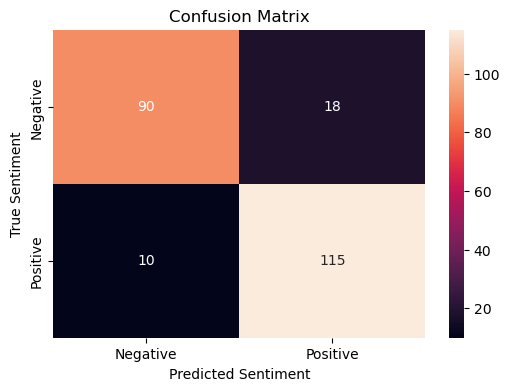

In [36]:
# Calculate the accuracy
accuracy = (roberta_df['LABELLED_SENTIMENT'] == roberta_df['PREDICTED_SENTIMENT']).mean()
print("Accuracy:", accuracy)

conf_mat = confusion_matrix(roberta_df['LABELLED_SENTIMENT'], roberta_df['PREDICTED_SENTIMENT'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.show()

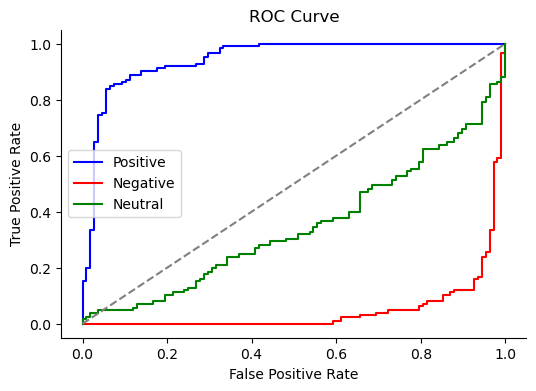

AUC - Positive: 0.94
AUC - Negative: 0.05
AUC - Neutral: 0.35


In [37]:
# columns for positive, negative, neutral
fpr_pos, tpr_pos, _ = roc_curve(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_pos'])
fpr_neg, tpr_neg, _ = roc_curve(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neg'])
fpr_neu, tpr_neu, _ = roc_curve(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neu'])

plt.figure(figsize=(6, 4))
plt.plot(fpr_pos, tpr_pos, color='b', label='Positive')
plt.plot(fpr_neg, tpr_neg, color='r', label='Negative')
plt.plot(fpr_neu, tpr_neu, color='g', label='Neutral')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
sns.despine()
plt.show()

# calculate the AUC (Area Under the Curve) for each
roc_auc_pos = roc_auc_score(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_pos'])
roc_auc_neg = roc_auc_score(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neg'])
roc_auc_neu = roc_auc_score(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neu'])

print(f'AUC - Positive: {roc_auc_pos:.2f}')
print(f'AUC - Negative: {roc_auc_neg:.2f}')
print(f'AUC - Neutral: {roc_auc_neu:.2f}')

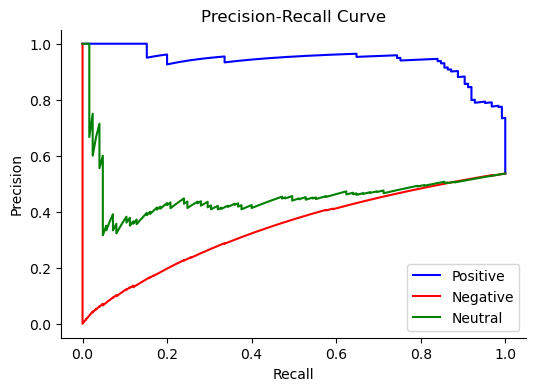

Average Precision - Positive: 0.94
Average Precision - Negative: 0.34
Average Precision - Neutral: 0.47


In [38]:
# columns for positive, negative, neutral
precision_pos, recall_pos, _ = precision_recall_curve(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_pos'])
precision_neg, recall_neg, _ = precision_recall_curve(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neg'])
precision_neu, recall_neu, _ = precision_recall_curve(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neu'])

plt.figure(figsize=(6, 4))
plt.plot(recall_pos, precision_pos, color='b', label='Positive')
plt.plot(recall_neg, precision_neg, color='r', label='Negative')
plt.plot(recall_neu, precision_neu, color='g', label='Neutral')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
sns.despine()
plt.show()

# If you want to calculate the Average Precision for each sentiment
avg_precision_pos = average_precision_score(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_pos'])
avg_precision_neg = average_precision_score(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neg'])
avg_precision_neu = average_precision_score(roberta_df['LABELLED_SENTIMENT'], roberta_df['roberta_neu'])

print(f'Average Precision - Positive: {avg_precision_pos:.2f}')
print(f'Average Precision - Negative: {avg_precision_neg:.2f}')
print(f'Average Precision - Neutral: {avg_precision_neu:.2f}')